## 0. Prerequisites

In [1]:
# packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io as scio
from factor_analyzer import FactorAnalyzer
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
from imblearn.over_sampling import SMOTE 

## 1. Expertise Classification

In [2]:
# transfer matlab struct data to pandas dataframe
data = scio.loadmat('research data/newdata.mat',struct_as_record=True)['allVPN']
keys = [data.dtype.descr[i][0] for i in range(len(data.dtype.descr))]
data_mat2pd = pd.DataFrame(index=range(1,data.shape[1]+1),columns=keys,dtype='double')
for i in range(data_mat2pd.shape[0]):
    data_mat2pd.iloc[i,0] = data[0][i][0][0]
    for j in range(1,data_mat2pd.shape[1]):
        data_mat2pd.iloc[i,j] = data[0][i][j][0][0]
data_mat2pd['expertise'] = pd.Categorical(data_mat2pd['expertise'])
data_mat2pd = data_mat2pd.drop(columns=data_mat2pd.loc[:,data_mat2pd.columns!='expertise'].columns[13],axis=1)
data_mat2pd

,expertise,Average_peak_velocity_of_saccades,Minimum_peak_velocity_of_saccades,Maximum_peak_velocity_of_saccades,Standard_deviation_of_peak_velocity_of_saccades,Average_amplitude_of_saccades,Minimum_amplitude_of_saccades,Maximum_amplitude_of_saccades,Total_amplitude_of_saccades,Amplitude_of_first_saccade,...,maxGyroY,stdGyroY,avgGyroZ,minGyroZ,maxGyroZ,stdGyroZ,meanspDispersion,minspDispersion,maxspDispersion,stdspDispersion
1,Expert,210.29,102.10,692.41,134.55,6.82,0.97,37.84,422.89,8.23,...,125.4468,25.627471,0.459666,-30.8379,56.1551,6.932179,928.867052,928.867052,928.867052,5.698189e-13
2,Expert,160.29,100.32,752.60,76.50,4.45,0.94,40.78,840.51,5.38,...,457.1159,39.537695,1.022927,-116.9386,162.3580,10.128204,1166.910451,1166.910451,1166.910451,7.278340e-12
3,R4,180.77,100.34,1338.03,193.66,3.64,0.43,27.91,272.86,3.31,...,320.7043,31.901832,0.424862,-111.5363,76.3964,7.780564,1344.464577,1344.464577,1344.464577,3.184287e-12
4,R4,194.28,100.28,854.48,97.56,4.44,0.50,24.02,2321.52,9.29,...,290.2483,15.694983,0.788296,-55.8373,162.0548,7.150270,1185.270433,1185.270433,1185.270433,5.913833e-12
5,R4,175.94,100.04,552.00,77.87,5.65,0.58,31.71,2120.59,5.33,...,314.7758,15.990401,0.707670,-73.5093,156.8781,5.681897,1475.423329,1475.423329,1475.423329,1.592093e-12
6,R3,193.52,100.34,788.64,106.37,6.19,0.92,35.87,3547.18,4.86,...,361.3256,19.562063,0.598923,-72.9051,137.1492,5.906137,1120.100442,1120.100442,1120.100442,9.097333e-12
7,R4,181.29,101.59,866.35,121.95,4.66,0.24,21.57,363.62,17.22,...,355.3515,22.953477,0.595141,-43.1609,33.4778,3.970143,1050.944813,1050.944813,1050.944813,4.553391e-13
8,R4,158.10,100.89,1279.52,117.54,3.81,0.26,34.74,525.13,3.81,...,199.0128,18.378910,0.741389,-48.3252,60.1744,5.393321,1133.442544,1133.442544,1133.442544,2.047981e-12
9,Expert,216.26,100.43,618.63,140.05,6.45,0.74,27.13,393.58,20.65,...,184.6567,22.306093,0.399799,-62.1250,53.1646,8.088887,1142.635550,1142.635550,1142.635550,2.277287e-12
10,R3,221.07,100.17,791.02,133.30,7.86,0.64,46.62,3276.90,8.12,...,420.2697,16.063098,0.551582,-201.3528,149.4042,6.884040,1413.430225,1413.430225,1413.430225,8.415643e-12


In [3]:
# data normalization
from sklearn import preprocessing
X, y = data_mat2pd.iloc[:,1:].values, data_mat2pd.iloc[:,0].values.codes
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [4]:
# Feature Selection: Anova F-Value with significant level = 0.05
from sklearn.feature_selection import SelectKBest, chi2, f_classif
idx_f = np.where(f_classif(X,y)[1]<0.05)[0] # p < 0.05, significant
skb = SelectKBest(f_classif,k=len(idx_f)).fit(X_scaled, y)
X_select_idx = np.where(skb.get_support()==True)[0]
X_select_features = data_mat2pd.columns[1:][X_select_idx].tolist()
X_select = skb.transform(X_scaled)

In [5]:
X_select_features # reduce feature number from 38 to 3

['Maximum_peak_velocity_of_saccades',
 'Minimum_amplitude_of_saccades',
 'stdSaccadeDuration']

In [6]:
## Bootstrap: random leave-one-out split the data and then return back, repeat for n times.
def random_loo_split_idx(y,times):
    idx_test = []
    for expert in np.unique(y):
        idx_expert = np.where(y==expert)[0]
        idxs = np.random.randint(0,len(idx_expert),size=times)
        idx_test.append([idx_expert[i] for i in idxs])
    return np.array(idx_test)

## Function for training and testing the data
def bootstrap_classfication(X,y,times,methods):
    idx_test = random_loo_split_idx(y,times)
    y_true, y_pred = [], []
    for t in range(times):
        idx_train = np.delete(np.arange(len(y)).tolist(),idx_test[:,t])
        X_train, X_test = X[idx_train], X[idx_test[:,t]]
        y_train, y_test = y[idx_train], y[idx_test[:,t]]
        # fit
        methods.fit(X_train,y_train)        
        ## correct count
        y_true += y_test.tolist()
        y_pred += methods.predict(X_test).tolist()
    return confusion_matrix(y_true, y_pred)

## Plot the confusion matrix
def confusion_display(cf,labels=None):
    disp = ConfusionMatrixDisplay(confusion_matrix=cf,display_labels=labels)
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax,values_format='')
    plt.show()

def bootstrap_classfication(X,y,times,methods):
    idx_test = random_loo_split_idx(y,times)
    count = np.zeros(len(np.unique(y)))
    for t in range(times):
        idx_train = np.delete(np.arange(len(y)).tolist(),idx_test[:,t])
        X_train, X_test = X[idx_train], X[idx_test[:,t]]
        y_train, y_test = y[idx_train], y[idx_test[:,t]]
        # fit
        methods.fit(X_train,y_train)        
        ## correct count
        count += (np.unique(y)==clf_rf.predict(X_test))
    return count/times, count.sum()/(len(count)*times)
## classify methods
# KNN
knn = KNeighborsClassifier(n_neighbors = 3,weights = "uniform",algorithm = "auto",leaf_size = 30,p = 1,metric = "manhattan")
# SVM
clf_svm = svm.SVC(decision_function_shape='ovo')
# Decision Tree
clf_dt = DecisionTreeClassifier()
# Random Forest
clf_rf = RandomForestClassifier(criterion='gini',max_depth=5,min_samples_leaf = 3,max_leaf_nodes = 4,random_state=0)

## test result
bootstrap_classfication(X_select,y,100,clf_rf)

In [7]:
## classify methods
# KNN
knn = KNeighborsClassifier(n_neighbors = 3,weights = "uniform",algorithm = "auto",leaf_size = 30,p = 1,metric = "manhattan")
# SVM
clf_svm = svm.SVC(decision_function_shape='ovo')
# Decision Tree
clf_dt = DecisionTreeClassifier()
# Random Forest
clf_rf = RandomForestClassifier(criterion='gini',max_depth=5,min_samples_leaf = 3,max_leaf_nodes = 4,random_state=0)

## test result
cf_expert = bootstrap_classfication(X_select,y,100,clf_rf)
cf_expert

array([[80, 20,  0],
       [18, 81,  1],
       [16,  4, 80]], dtype=int64)

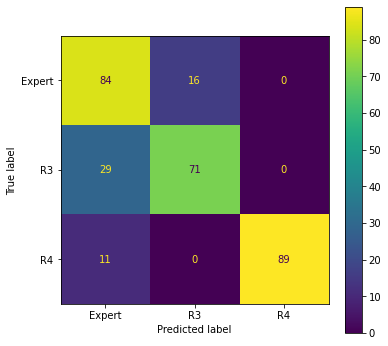

In [1010]:
confusion_display(cf_expert,np.unique(data_mat2pd['expertise']))

## 2. Confusion Event

In [8]:
# function
# transfer matlab confusion data to pandas dataframe
def read_mat2pd(name,keys,path):
    data = scio.loadmat('{}/{}.mat'.format(path,name),struct_as_record=True)['{}'.format(name)]
    data = pd.DataFrame(data,index=range(1,data.shape[0]+1),dtype='double').drop(columns=0,axis=1)
    data.columns = keys
    return data

def get_binary_data(data):
    if type(data) == pd.core.frame.DataFrame:
        X, y = data.iloc[:,:-1].values, data_confusion.iloc[:,-1].values
    else:
        X, y = data[:,-1], data[:,-1]
    idx_0, idx_1 = np.where(y==0)[0], np.where(y==1)[0]
    prt_0, prt_1 = np.unique(X[idx_0,0].astype(int)), np.unique(X[idx_1,0].astype(int))
    dat_0, dat_1 = [data.iloc[np.where(X[:,0]==i)[0],:] for i in prt_0], [data.iloc[np.where(X[:,0]==i)[0],:] for i in prt_1]
    return dat_0, dat_1

def random_pick(data,n_samples):
    idx_rp = np.random.choice(data.shape[0], size=min(n_samples,data.shape[0]), replace=False)
    if type(data) == pd.core.frame.DataFrame:
        return data.iloc[idx_rp,:-1].values, data.iloc[idx_rp,-1].values
    else:
        return data[idx_rp,:-1], data[idx_rp,-1]
        
def set_combine(data1,data2,n_samples):
    X_1, y_1 = random_pick(data1,n_samples)
    X_2, y_2 = random_pick(data2,n_samples)
    X_combine, y_combine = np.r_[X_1,X_2], np.r_[y_1,y_2]
    return X_combine, y_combine

def normalized_datalist(datalist,col_feature):
    for i,d in enumerate(datalist):
        unnormalized = d.iloc[:,col_feature].copy()
        d.iloc[:,col_feature] = preprocessing.StandardScaler().fit(unnormalized).transform(unnormalized)

In [441]:
# transfer matlab confusion data to pandas dataframe
lab_confusion = ['curVP','currentTime','gazeX','gazeY','pupilPos_combined','pupilDiameter_combined','gyroX','gyroY','gyroZ','accX','accY','accZ','confused']
#data_confusion = read_mat2pd('VP_sequences',lab_confusion,'research data')
data_confusion = pd.read_csv('vp_sequence.csv',index_col=0)
# add feature expert
idx_r3 = np.where(data_mat2pd['expertise']!='Expert')[0]+1
#idx_r3 = np.where(data_mat2pd['expertise']=='r3')[0]+1
idx_novice = 0
for i in idx_r3:
    idx_novice += (data_confusion['curVP']==i).values
data_confusion.insert(2,'novice',idx_novice)
data_confusion

,curVP,currentTime,novice,gazeX,gazeY,pupilPos_combined,pupilDiameter_combined,gyroX,gyroY,gyroZ,accX,accY,accZ,confused
0,1.0,0.005165,0,855.0,363.0,66.936884,4.030,-4.20,0.3125,2.2586,-1.5298,-9.7258,-1.3166,0.0
1,1.0,0.015154,0,856.0,363.0,66.646658,4.040,-4.27,0.4584,1.4313,-1.5298,-9.7712,-1.2848,0.0
2,1.0,0.025146,0,856.0,363.0,66.946883,4.030,-4.48,0.3692,1.1313,-1.5298,-9.7712,-1.2848,0.0
3,1.0,0.035138,0,856.0,364.0,66.656880,4.035,-5.11,0.3813,1.0624,-1.5298,-9.8030,-1.3302,0.0
4,1.0,0.045135,0,856.0,364.0,66.946883,4.030,-5.60,0.3124,1.0502,-1.5298,-9.7962,-1.3689,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6438,15.0,113.540250,0,1038.0,233.0,70.692379,3.070,-0.77,-1.2895,0.0569,0.1961,-9.8688,-0.5054,0.0
6439,15.0,113.550039,0,1037.0,230.0,70.933039,3.055,-0.42,-0.9205,-0.0201,0.1569,-9.8302,-0.4985,0.0
6440,15.0,113.559828,0,1036.0,228.0,70.682380,3.075,-0.14,-0.2028,-0.4622,0.0785,-9.7848,-0.5304,0.0
6441,15.0,113.605432,0,1035.0,229.0,70.922850,3.055,0.00,1.0703,-1.2329,0.1961,-9.9461,-0.5190,0.0


In [442]:
number_of_confused = [(data_confusion.iloc[:,-1]==0).sum(),(data_confusion.iloc[:,-1]==1).sum()]
idx_no_event, idx_confusion = np.where(data_confusion.iloc[:,-1]==0)[0], np.where(data_confusion.iloc[:,-1]==1)[0]
prt_no_event, prt_confusion = np.unique(data_confusion.iloc[idx_no_event,0].astype(int)), np.unique(data_confusion.iloc[idx_confusion,0].astype(int))
number_of_confused, prt_no_event, prt_confusion

([258367, 122957],
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]),
 array([ 3,  4,  5,  6, 10, 13]))

In [443]:
prt_overlap, prt_unoverlap = np.intersect1d(prt_no_event, prt_confusion), np.setdiff1d(prt_no_event, prt_confusion)
prt_overlap, prt_unoverlap

(array([ 3,  4,  5,  6, 10, 13]), array([ 1,  2,  7,  8,  9, 11, 12, 14, 15]))

In [444]:
f_classif(data_confusion.iloc[:,3:-1],data_confusion.iloc[:,-1])[1].reshape(1,-1).shape

(1, 10)

In [445]:
pd.DataFrame(f_classif(data_confusion.iloc[:,3:-1],data_confusion.iloc[:,-1])[1].reshape(1,-1),columns=lab_confusion[2:-1])

,gazeX,gazeY,pupilPos_combined,pupilDiameter_combined,gyroX,gyroY,gyroZ,accX,accY,accZ
0,0.00175,1.259301e-57,0.0,0.0,1.884138e-15,0.0932,0.917728,0.009833,3.800381e-155,3.374965e-238


In [333]:
# Anova F-value
idx_fc = np.where(f_classif(data_confusion.iloc[:,2:-1],data_confusion.iloc[:,-1])[1]<0.05)[0] # p < 0.05, significant
col_X = data_confusion.iloc[:,2:-1].columns[idx_fc].tolist()
#col_feature = col_X + ['confused']
col_data = ['curVP','currentTime'] + col_X + ['confused']
data_confusion = data_confusion[col_data]
data_confusion

,curVP,currentTime,novice,gazeX,gazeY,pupilPos_combined,pupilDiameter_combined,gyroY,gyroZ,accX,accY,accZ,confused
1,1.0,6.465679e+06,0,977.488511,218.123876,66.765152,3.946923,0.918789,-0.466776,-0.583775,-9.816084,-0.032441,0.0
2,1.0,6.478637e+06,0,977.777223,217.917083,66.765092,3.946918,0.920166,-0.471362,-0.581972,-9.816201,-0.030870,0.0
3,1.0,6.491594e+06,0,978.087912,217.733267,66.765442,3.947023,0.921126,-0.475596,-0.580209,-9.816313,-0.029338,0.0
4,1.0,6.504551e+06,0,978.389610,217.536464,66.765372,3.947043,0.922296,-0.480218,-0.578445,-9.816424,-0.027806,0.0
5,1.0,6.517510e+06,0,978.688312,217.342657,66.765540,3.947058,0.923061,-0.484556,-0.576643,-9.816535,-0.026273,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
527860,15.0,1.565685e+08,0,936.789211,240.053946,70.774317,2.935030,-3.812172,0.355947,0.433296,-9.805316,-0.873654,0.0
527861,15.0,1.565958e+08,0,936.654346,240.182817,70.774471,2.935310,-3.794920,0.346704,0.432629,-9.805069,-0.873253,0.0
527862,15.0,1.566232e+08,0,936.524476,240.311688,70.774845,2.935569,-3.780719,0.340261,0.432316,-9.804962,-0.872955,0.0
527863,15.0,1.566505e+08,0,936.401598,240.438561,70.775028,2.935849,-3.769053,0.333300,0.432002,-9.805119,-0.872744,0.0


In [334]:
# datalist for both 0 and 1
datalist_0, datalist_1 = get_binary_data(data_confusion)
data_0, data_1 = pd.concat(datalist_0,axis=0), pd.concat(datalist_1,axis=0)

In [335]:
def random_choice(data,test_size):
    idx_test = np.random.choice(len(data),size=test_size,replace=False)
    idx_train = np.delete(np.arange(len(data)),idx_test)
    return pd.concat(data[i] for i in idx_train), pd.concat(data[i] for i in idx_test)

def idx_cut(cut_length,data):
    return np.random.choice(data.shape[0],size=cut_length,replace=False)

def equal_concat(data0,data1,cut_length=None):
    if cut_length is None:
        cut_length = min(data0.shape[0],data1.shape[0])
    else:
        cut_length = min(data0.shape[0],data1.shape[0],cut_length)
    idx_data0, idx_data1 = idx_cut(cut_length,data0), idx_cut(cut_length,data1)
    return pd.concat([data0.iloc[idx_data0,:],data1.iloc[idx_data1,:]])

In [338]:
train_0, test_0 = random_choice(datalist_0,3)
train_1, test_1 = random_choice(datalist_1,2)
data_train, data_test = equal_concat(train_0,train_1), equal_concat(test_0,test_1)
X_train1, X_test1 = data_train.iloc[:,3:-1].values, data_test.iloc[:,3:-1].values
y_train1, y_test1 = data_train.iloc[:,-1].values, data_test.iloc[:,-1].values
scaler = preprocessing.StandardScaler().fit(X_train1)
X_train1 = scaler.transform(X_train1)
X_test1 = scaler.transform(X_test1)

In [339]:
np.unique(train_0['curVP']),np.unique(train_1['curVP']),np.unique(test_0['curVP']),np.unique(test_1['curVP'])

(array([ 7.,  8., 11., 12., 14., 15.]),
 array([ 4.,  5., 13.]),
 array([1., 2., 9.]),
 array([ 6., 10.]))

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
knn = KNeighborsClassifier()
clf_lsvm = svm.LinearSVC()
clf_dt = DecisionTreeClassifier()
clf_rf = RandomForestClassifier()

mod = clf_dt
mod.fit(X_train1,y_train1)
test_pred = mod.predict(X_test1)
(test_pred==y_test1).mean()
#mod.score(X_train1,y_train1)

In [17]:
def pick_samples_train_test(datalist,n_samples1,n_samples2,test_size):
    idx_dl_test = np.random.choice(len(datalist),size=test_size,replace=False)
    idx_dl_train = np.delete(np.arange(len(datalist)),idx_dl_test)
    dl_train, dl_test = [], []
    for i in idx_dl_train:
        idx_samples = np.random.choice(len(datalist[i]),size=n_samples1,replace=False)
        dl_train.append(datalist[i].iloc[idx_samples])
    for i in idx_dl_test:
        idx_samples = np.random.choice(len(datalist[i]),size=n_samples2,replace=False)
        dl_test.append(datalist[i].iloc[idx_samples])
    return pd.concat(dl_train), pd.concat(dl_test)

train_00, test_00 = pick_samples_train_test(datalist_0,200,2000,3)
train_01, test_01 = pick_samples_train_test(datalist_1,400,3000,2)
train_00.shape[0],train_01.shape[0],test_00.shape[0],test_01.shape[0]
train_a, test_a = pd.concat([train_00,train_01]), pd.concat([test_00,test_01])
X_train1, y_train1 = train_a.iloc[:,3:-1].values, train_a.iloc[:,-1].values
X_test1, y_test1 = test_a.iloc[:,3:-1].values, test_a.iloc[:,-1].values
scaler = preprocessing.StandardScaler().fit(X_train1)
#X_train1 = scaler.transform(X_train1)
#X_test1 = scaler.transform(X_test1)
X_train1 = np.c_[train_a['novice'].values,scaler.transform(X_train1)]
X_test1 = np.c_[test_a['novice'].values,scaler.transform(X_test1)]
np.unique(train_00['curVP']),np.unique(train_01['curVP']),np.unique(test_00['curVP']),np.unique(test_01['curVP']),np.unique(train_a['curVP']),np.unique(test_a['curVP'])

In [19]:
def idx_VPN(prt):
    idx_plist = []
    for i,p in enumerate(prt):
        idx_plist += np.where(data_confusion['curVP']==p)[0].tolist()
    return idx_plist

In [316]:
# Random split participants to training and testing set
from sklearn.model_selection import train_test_split
#prt_0, prt_1 = train_test_split(prt_unoverlap,test_size=1/3), train_test_split(prt_overlap,test_size=1/3)
prt_0, prt_1 = train_test_split(prt_unoverlap,test_size=1/3), train_test_split(np.delete(prt_overlap,0),test_size=1/3)
prt_train, prt_test = [prt_0[i].tolist() + prt_1[i].tolist() for i in range(2)]
#prt_train, prt_test = prt_1
prt_train, prt_test

([15, 8, 11, 12, 7, 9, 6, 13, 4], [14, 1, 2, 10, 5])

In [317]:
idx_train, idx_test = idx_VPN(prt_train), idx_VPN(prt_test)
data_train, data_test = data_confusion.iloc[idx_train], data_confusion.iloc[idx_test]
X_train1, X_test1 = data_train.iloc[:,3:-1].values, data_test.iloc[:,3:-1].values
y_train1, y_test1 = data_train.iloc[:,-1].values, data_test.iloc[:,-1].values
scaler = preprocessing.StandardScaler().fit(X_train1)
X_train1 = scaler.transform(X_train1)
X_test1 = scaler.transform(X_test1)
#X_train1 = np.c_[data_train['novice'].values,scaler.transform(X_train1)]
#X_test1 = np.c_[data_test['novice'].values,scaler.transform(X_test1)]

In [340]:
from imblearn.ensemble import BalancedBaggingClassifier
bbc = BalancedBaggingClassifier(random_state=42)
bbc.fit(X_train1, y_train1) 
y_pred1 = bbc.predict(X_test1)
print(confusion_matrix(y_test1, y_pred1))

[[17462 32396]
 [28045 21813]]


In [341]:
# SMOTEENN Method
from imblearn.combine import SMOTEENN, SMOTETomek
sme = SMOTEENN()
X_train1, y_train1 = sme.fit_resample(X_train1,y_train1)
X_test1, y_test1 = sme.fit_resample(X_test1,y_test1)

In [342]:
scaler = preprocessing.StandardScaler().fit(X_train1)
X_train1 = scaler.transform(X_train1)
X_test1 = scaler.transform(X_test1)

In [343]:
from sklearn.utils.class_weight import compute_class_weight
y_confusion = y_train1
y_label = np.unique(y_confusion)
cw = compute_class_weight(class_weight='balanced',classes=y_label,y=y_confusion)
cw_dict = dict(enumerate(cw))
cw_dict

{0: 1.0, 1: 1.0}

In [344]:
from sklearn.linear_model import LogisticRegression
mod = LogisticRegression()
mod.fit(X_train1,y_train1)
test_pred = mod.predict(X_test1)
mod.score(X_test1,y_test1) # (test_pred==y_test1).mean()

0.32814192306149464

In [345]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
knn = KNeighborsClassifier()
clf_dt = DecisionTreeClassifier()
clf_rf = RandomForestClassifier(class_weight=cw_dict)
mod = clf_rf
mod.fit(X_train1,y_train1)
test_pred = mod.predict(X_test1)
mod.score(X_test1,y_test1) # (test_pred==y_test1).mean()

0.3431244735047535

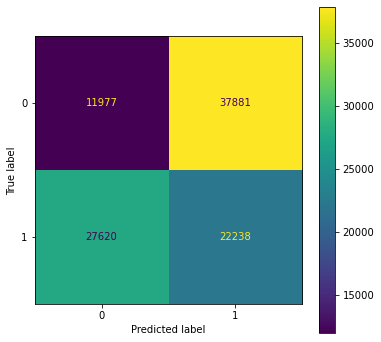

In [346]:
confusion_display(confusion_matrix(y_test1,test_pred))

In [347]:
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(units=64, activation='linear', input_dim=X_train1.shape[1]))
model.add(Dense(units=48, activation='sigmoid'))
model.add(Dense(units=32, activation='linear'))
model.add(Dense(units=16, activation='softsign'))
#model.add(Dense(units=8, activation='linear'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='RMSprop',
              metrics=['binary_accuracy'])
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_158 (Dense)           (None, 64)                640       
                                                                 
 dense_159 (Dense)           (None, 48)                3120      
                                                                 
 dense_160 (Dense)           (None, 32)                1568      
                                                                 
 dense_161 (Dense)           (None, 16)                528       
                                                                 
 dense_162 (Dense)           (None, 1)                 17        
                                                                 
Total params: 5,873
Trainable params: 5,873
Non-trainable params: 0
_________________________________________________________________


In [348]:
model_history = model.fit(X_train1, y_train1, epochs=5, batch_size=30,class_weight=cw_dict)

Epoch 1/5
9942/9942 [==============================] - 6s 564us/step - loss: 0.0503 - binary_accuracy: 0.9712
Epoch 2/5
9942/9942 [==============================] - 6s 567us/step - loss: 7.9367e-04 - binary_accuracy: 0.9998
Epoch 3/5
9942/9942 [==============================] - 6s 594us/step - loss: 7.3238e-05 - binary_accuracy: 1.0000
Epoch 4/5
9942/9942 [==============================] - 6s 555us/step - loss: 1.4219e-09 - binary_accuracy: 1.0000
Epoch 5/5
9942/9942 [==============================] - 6s 594us/step - loss: 1.2596e-09 - binary_accuracy: 1.0000


In [349]:
loss_and_metrics = model.evaluate(X_test1, y_test1, batch_size=10)

9972/9972 [==============================] - 4s 408us/step - loss: 15.2007 - binary_accuracy: 0.3373


In [350]:
classes = model.predict(X_test1, batch_size=32)
((classes>0.5).flatten()==y_test1).mean()

0.33732801155281

In [351]:
confusion_matrix(y_test1,model.predict(X_test1)>0.5)

array([[12607, 37251],
       [28828, 21030]], dtype=int64)

In [736]:
true, pred_rf, pred_nn, score_rf, score_nn = [], [], [], [], []
for i in tqdm(range(10)):
    prt_0, prt_1 = train_test_split(prt_unoverlap,test_size=1/3), train_test_split(prt_overlap,test_size=1/3)
    prt_train, prt_test = [prt_0[i].tolist() + prt_1[i].tolist() for i in range(2)]
    idx_train, idx_test = idx_VPN(prt_train), idx_VPN(prt_test)
    data_train, data_test = data_confusion.iloc[idx_train], data_confusion.iloc[idx_test]
    X_train1, X_test1 = data_train.iloc[:,3:-1].values, data_test.iloc[:,3:-1].values
    y_train1, y_test1 = data_train.iloc[:,-1].values, data_test.iloc[:,-1].values
    scaler = preprocessing.StandardScaler().fit(X_train1)
    X_train1 = scaler.transform(X_train1)
    X_test1 = scaler.transform(X_test1)
    
    true += y_test1.tolist()
    clf_rf = RandomForestClassifier()
    mod = clf_rf
    mod.fit(X_train1,y_train1)
    pred_rf += mod.predict(X_test1).tolist()
    score_rf.append(mod.score(X_test1,y_test1))
    
    model = Sequential()
    model.add(Dense(units=128, activation='linear', input_dim=X_train1.shape[1]))
    model.add(Dense(units=64, activation='softsign'))
    model.add(Dense(units=32, activation='linear'))
    model.add(Dense(units=16, activation='softsign'))
    model.add(Dense(units=8, activation='linear'))
    model.add(Dense(units=1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                  optimizer='RMSprop',
                  metrics=['binary_accuracy'])
    model.fit(X_train1, y_train1, epochs=5, batch_size=30)
    loss_and_metrics = model.evaluate(X_test1, y_test1, batch_size=10)
    pred_nn += (model.predict(X_test1)>0.5).tolist()
    score_nn.append(loss_and_metrics[1])
    
cf_rf, cf_nn = confusion_matrix(true, pred_rf), confusion_matrix(true, pred_nn)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Epoch 1/5
10622/10622 [==============================] - 7s 584us/step - loss: 0.2944 - binary_accuracy: 0.8699
Epoch 2/5
10622/10622 [==============================] - 6s 588us/step - loss: 0.2470 - binary_accuracy: 0.8954
Epoch 3/5
10622/10622 [==============================] - 6s 559us/step - loss: 0.2325 - binary_accuracy: 0.9020
Epoch 4/5
10622/10622 [==============================] - 6s 563us/step - loss: 0.2256 - binary_accuracy: 0.9051
Epoch 5/5
6270/6270 [==============================] - 3s 422us/step - loss: 1.7021 - binary_accuracy: 0.6015


 10%|████████▎                                                                          | 1/10 [01:15<11:15, 75.06s/it]

Epoch 1/5
8577/8577 [==============================] - 5s 583us/step - loss: 0.2920 - binary_accuracy: 0.8704
Epoch 2/5
8577/8577 [==============================] - 5s 576us/step - loss: 0.2347 - binary_accuracy: 0.9021
Epoch 3/5
8577/8577 [==============================] - 5s 581us/step - loss: 0.2171 - binary_accuracy: 0.9098
Epoch 4/5
8577/8577 [==============================] - 5s 581us/step - loss: 0.2066 - binary_accuracy: 0.9149
Epoch 5/5
12405/12405 [==============================] - 5s 411us/step - loss: 1.9982 - binary_accuracy: 0.7682


 20%|████████████████▌                                                                  | 2/10 [02:19<09:11, 68.98s/it]

Epoch 1/5
9284/9284 [==============================] - 6s 564us/step - loss: 0.3232 - binary_accuracy: 0.8532
Epoch 2/5
9284/9284 [==============================] - 5s 579us/step - loss: 0.2637 - binary_accuracy: 0.8874
Epoch 3/5
9284/9284 [==============================] - 5s 587us/step - loss: 0.2474 - binary_accuracy: 0.8957
Epoch 4/5
9284/9284 [==============================] - 5s 552us/step - loss: 0.2396 - binary_accuracy: 0.8996
Epoch 5/5
10281/10281 [==============================] - 4s 414us/step - loss: 0.8828 - binary_accuracy: 0.7083


 30%|████████████████████████▉                                                          | 3/10 [03:28<08:02, 68.91s/it]

Epoch 1/5
9023/9023 [==============================] - 6s 575us/step - loss: 0.2974 - binary_accuracy: 0.8697
Epoch 2/5
9023/9023 [==============================] - 5s 598us/step - loss: 0.2329 - binary_accuracy: 0.9014
Epoch 3/5
9023/9023 [==============================] - 5s 583us/step - loss: 0.2121 - binary_accuracy: 0.9112
Epoch 4/5
9023/9023 [==============================] - 5s 595us/step - loss: 0.2031 - binary_accuracy: 0.9158
Epoch 5/5
11065/11065 [==============================] - 5s 417us/step - loss: 2.0406 - binary_accuracy: 0.5328


 40%|█████████████████████████████████▏                                                 | 4/10 [04:38<06:55, 69.18s/it]

Epoch 1/5
10377/10377 [==============================] - 7s 591us/step - loss: 0.3171 - binary_accuracy: 0.8587
Epoch 2/5
10377/10377 [==============================] - 6s 601us/step - loss: 0.2651 - binary_accuracy: 0.8873
Epoch 3/5
10377/10377 [==============================] - 6s 604us/step - loss: 0.2501 - binary_accuracy: 0.8953
Epoch 4/5
10377/10377 [==============================] - 6s 623us/step - loss: 0.2418 - binary_accuracy: 0.8993
Epoch 5/5
7002/7002 [==============================] - 3s 422us/step - loss: 1.1344 - binary_accuracy: 0.8064


 50%|█████████████████████████████████████████▌                                         | 5/10 [05:54<05:59, 71.85s/it]

Epoch 1/5
9081/9081 [==============================] - 6s 575us/step - loss: 0.2913 - binary_accuracy: 0.8704
Epoch 2/5
9081/9081 [==============================] - 5s 586us/step - loss: 0.2347 - binary_accuracy: 0.8994
Epoch 3/5
9081/9081 [==============================] - 5s 589us/step - loss: 0.2143 - binary_accuracy: 0.9081
Epoch 4/5
9081/9081 [==============================] - 5s 588us/step - loss: 0.2043 - binary_accuracy: 0.9138
Epoch 5/5
10891/10891 [==============================] - 5s 418us/step - loss: 2.3504 - binary_accuracy: 0.4869


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [07:03<04:42, 70.65s/it]

Epoch 1/5
7508/7508 [==============================] - 5s 589us/step - loss: 0.3099 - binary_accuracy: 0.8593
Epoch 2/5
7508/7508 [==============================] - 5s 607us/step - loss: 0.2467 - binary_accuracy: 0.8955
Epoch 3/5
7508/7508 [==============================] - 5s 635us/step - loss: 0.2254 - binary_accuracy: 0.9054
Epoch 4/5
7508/7508 [==============================] - 4s 572us/step - loss: 0.2135 - binary_accuracy: 0.9108
Epoch 5/5
15612/15612 [==============================] - 7s 442us/step - loss: 1.4380 - binary_accuracy: 0.7388


 70%|██████████████████████████████████████████████████████████                         | 7/10 [08:03<03:22, 67.45s/it]

Epoch 1/5
7801/7801 [==============================] - 5s 560us/step - loss: 0.3061 - binary_accuracy: 0.8609
Epoch 2/5
7801/7801 [==============================] - 4s 565us/step - loss: 0.2573 - binary_accuracy: 0.8894
Epoch 3/5
7801/7801 [==============================] - 4s 564us/step - loss: 0.2438 - binary_accuracy: 0.8959
Epoch 4/5
7801/7801 [==============================] - 5s 582us/step - loss: 0.2353 - binary_accuracy: 0.9007
Epoch 5/5
14730/14730 [==============================] - 6s 425us/step - loss: 1.5460 - binary_accuracy: 0.6816


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [09:04<02:10, 65.39s/it]

Epoch 1/5
8199/8199 [==============================] - 5s 603us/step - loss: 0.3020 - binary_accuracy: 0.8655
Epoch 2/5
8199/8199 [==============================] - 5s 601us/step - loss: 0.2485 - binary_accuracy: 0.8938
Epoch 3/5
8199/8199 [==============================] - 5s 600us/step - loss: 0.2344 - binary_accuracy: 0.9005
Epoch 4/5
8199/8199 [==============================] - 5s 604us/step - loss: 0.2268 - binary_accuracy: 0.9047
Epoch 5/5
13537/13537 [==============================] - 5s 392us/step - loss: 1.2030 - binary_accuracy: 0.7123


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [10:07<01:04, 64.56s/it]

Epoch 1/5
7733/7733 [==============================] - 5s 599us/step - loss: 0.2657 - binary_accuracy: 0.8808
Epoch 2/5
7733/7733 [==============================] - 4s 556us/step - loss: 0.2076 - binary_accuracy: 0.9110
Epoch 3/5
7733/7733 [==============================] - 4s 572us/step - loss: 0.1881 - binary_accuracy: 0.9214
Epoch 4/5
7733/7733 [==============================] - 5s 586us/step - loss: 0.1789 - binary_accuracy: 0.9259
Epoch 5/5
14936/14936 [==============================] - 6s 414us/step - loss: 3.2090 - binary_accuracy: 0.4471


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [11:05<00:00, 66.55s/it]


In [719]:
np.diag(cf_rf).sum()/cf_rf.sum(), np.diag(cf_nn).sum()/cf_nn.sum()

(0.6637876398142633, 0.6268053834150098)

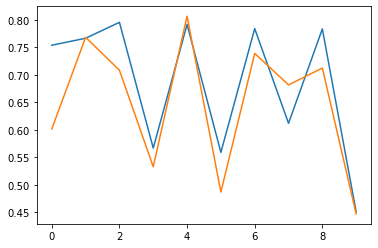

In [738]:
plt.plot(score_rf)
plt.plot(score_nn)

In [883]:
cf_nn

array([[744754,  99931],
       [314113,   8432]], dtype=int64)

train_0, train_1 = read_mat2pd('train_0',lab_confusion,'research data'), read_mat2pd('train_1',lab_confusion,'research data')
test_0, test_1 = read_mat2pd('test_0',lab_confusion,'research data'), read_mat2pd('test_1',lab_confusion,'research data')
data_train, data_test = pd.concat([train_0,train_1],axis=0), pd.concat([test_0,test_1],axis=0)
X_ctrain, X_ctest = data_train.iloc[:,1:-1].values, data_test.iloc[:,1:-1].values
y_ctrain, y_ctest = data_train.iloc[:,-1].values, data_test.iloc[:,-1].values

In [400]:
train_0, train_1 = read_mat2pd('train_0',lab_confusion,'research data'), read_mat2pd('train_1',lab_confusion,'research data')
test_0, test_1 = read_mat2pd('test_0',lab_confusion,'research data'), read_mat2pd('test_1',lab_confusion,'research data')
data_train, data_test = pd.concat([train_0,train_1],axis=0).drop(columns='gyroX'), pd.concat([test_0,test_1],axis=0).drop(columns='gyroX')
idx_novice = np.where(data_mat2pd['expertise']!='Expert')[0]+1
idx_novice_train, idx_novice_test = 0, 0
for i in idx_novice:
    idx_novice_train += (data_train['curVP']==i).values
    idx_novice_test += (data_test['curVP']==i).values
data_train.insert(2,'novice',idx_novice_train)
data_test.insert(2,'novice',idx_novice_test)
X_ctrain, X_ctest = data_train.iloc[:,3:-1].values, data_test.iloc[:,3:-1].values
y_ctrain, y_ctest = data_train.iloc[:,-1].values, data_test.iloc[:,-1].values
scaler = preprocessing.StandardScaler().fit(X_ctrain)
X_ctrain = scaler.transform(X_ctrain)
X_ctest = scaler.transform(X_ctest)
# for dummy variable: Experience not enough
#X_ctrain = np.c_[data_train['novice'],scaler.transform(X_ctrain)]
#X_ctest = np.c_[data_test['novice'],scaler.transform(X_ctest)]

from sklearn.svm import LinearSVC
knn = KNeighborsClassifier()
clf_lsvm = svm.LinearSVC()
clf_dt = DecisionTreeClassifier()
clf_rf = RandomForestClassifier()

In [353]:
train_0.shape[0],train_1.shape[0],test_0.shape[0],test_1.shape[0]

(139381, 139381, 263590, 263590)

In [354]:
np.unique(train_0['curVP'].values),np.unique(train_1['curVP'].values),np.unique(test_0['curVP'].values),np.unique(test_1['curVP'].values)

(array([ 1.,  2., 11., 14.]),
 array([4., 5., 6.]),
 array([ 1.,  2.,  7., 11., 14., 15.]),
 array([ 4.,  5.,  6., 10., 13.]))

In [355]:
mod = clf_rf
mod.fit(X_ctrain,y_ctrain)
#test_pred = mod.predict(X_ctest)
mod.score(X_ctest,y_ctest) # (test_pred==y_ctest).mean()

0.8345821161652567

In [356]:
mod = clf_dt
mod.fit(X_ctrain,y_ctrain)
#test_pred = mod.predict(X_ctest)
mod.score(X_ctest,y_ctest) # (test_pred==y_ctest).mean()

0.8376285139800448

In [402]:
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(units=128, activation='linear', input_dim=X_ctrain.shape[1]))
model.add(Dense(units=64, activation='exponential'))
model.add(Dense(units=32, activation='hard_sigmoid'))
model.add(Dense(units=16, activation='softplus'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='RMSprop',
              metrics=['binary_accuracy'])
model.summary()

Model: "sequential_35"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_199 (Dense)           (None, 128)               1280      
                                                                 
 dense_200 (Dense)           (None, 64)                8256      
                                                                 
 dense_201 (Dense)           (None, 32)                2080      
                                                                 
 dense_202 (Dense)           (None, 16)                528       
                                                                 
 dense_203 (Dense)           (None, 1)                 17        
                                                                 
Total params: 12,161
Trainable params: 12,161
Non-trainable params: 0
_________________________________________________________________


In [403]:
model.fit(X_ctrain,y_ctrain, epochs=5, batch_size=300)

Epoch 1/5
930/930 [==============================] - 1s 1ms/step - loss: 0.0302 - binary_accuracy: 0.9898
Epoch 2/5
930/930 [==============================] - 1s 1ms/step - loss: 1.3051e-05 - binary_accuracy: 1.0000
Epoch 3/5
930/930 [==============================] - 1s 1ms/step - loss: 2.8606e-09 - binary_accuracy: 1.0000
Epoch 4/5
930/930 [==============================] - 1s 1ms/step - loss: 2.1669e-09 - binary_accuracy: 1.0000
Epoch 5/5
930/930 [==============================] - 1s 1ms/step - loss: 1.9259e-09 - binary_accuracy: 1.0000


In [404]:
loss_and_metrics = model.evaluate(X_ctest, y_ctest, batch_size=1000)

528/528 [==============================] - 1s 826us/step - loss: 3.2940 - binary_accuracy: 0.8514


In [405]:
classes_pred = model.predict(X_ctest, batch_size=1000)>0.5
(classes_pred.flatten()==y_ctest).mean()

0.8514454266095072

In [406]:
cf_nn1 = confusion_matrix(y_ctest,classes_pred)

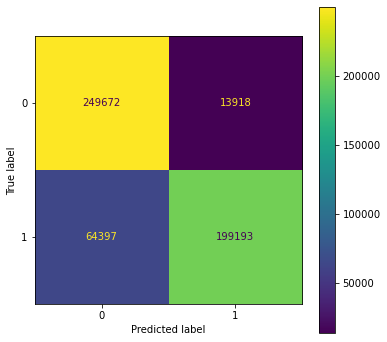

In [407]:
confusion_display(cf_nn1)

In [370]:
np.diag(cf_nn1).sum()/cf_nn1.sum(), np.diag(cf_nn1)/cf_nn1.sum(1)

(0.8537823893167419, array([0.94222467, 0.76534011]))

In [371]:
from sklearn.svm import LinearSVC
knn = KNeighborsClassifier()
clf_lsvm = svm.LinearSVC()
clf_dt = DecisionTreeClassifier()
clf_rf = RandomForestClassifier()
X_ctrain.shape

(278762, 9)

In [372]:
from keras.models import Sequential
from keras.layers import Dense
model = Sequential()
model.add(Dense(units=128, activation='linear', input_dim=X_ctrain.shape[1]))
model.add(Dense(units=64, activation='softsign'))
model.add(Dense(units=32, activation='linear'))
model.add(Dense(units=16, activation='softsign'))
model.add(Dense(units=8, activation='linear'))
model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
              optimizer='RMSprop',
              metrics=['binary_accuracy'])
model.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_168 (Dense)           (None, 128)               1280      
                                                                 
 dense_169 (Dense)           (None, 64)                8256      
                                                                 
 dense_170 (Dense)           (None, 32)                2080      
                                                                 
 dense_171 (Dense)           (None, 16)                528       
                                                                 
 dense_172 (Dense)           (None, 8)                 136       
                                                                 
 dense_173 (Dense)           (None, 1)                 9         
                                                                 
Total params: 12,289
Trainable params: 12,289
Non-tra

In [373]:
model.fit(X_ctrain,y_ctrain, epochs=5, batch_size=300)

Epoch 1/5
930/930 [==============================] - 1s 1ms/step - loss: 0.0321 - binary_accuracy: 0.9884
Epoch 2/5
930/930 [==============================] - 1s 1ms/step - loss: 1.3093e-04 - binary_accuracy: 1.0000
Epoch 3/5
930/930 [==============================] - 1s 1ms/step - loss: 3.8920e-09 - binary_accuracy: 1.0000
Epoch 4/5
930/930 [==============================] - 1s 1ms/step - loss: 1.3228e-09 - binary_accuracy: 1.0000
Epoch 5/5
930/930 [==============================] - 1s 1ms/step - loss: 9.0132e-10 - binary_accuracy: 1.0000


In [374]:
loss_and_metrics = model.evaluate(X_ctest, y_ctest, batch_size=100)

5272/5272 [==============================] - 3s 499us/step - loss: 4.2698 - binary_accuracy: 0.8202


In [375]:
classes_pred = model.predict(X_ctest, batch_size=100)>0.5
(classes_pred.flatten()==y_ctest).mean()

0.8202454569596722

In [376]:
cf_nn2 = confusion_matrix(y_ctest,classes_pred)

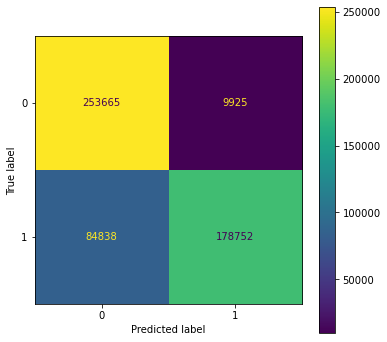

In [377]:
confusion_display(cf_nn2)

In [1080]:
np.diag(cf_nn2).sum()/cf_nn2.sum(), np.diag(cf_nn2)/cf_nn2.sum(1)

(0.8176960430972343, array([0.95792329, 0.6774688 ]))